<a href="https://colab.research.google.com/github/MohimenMG/Auto-Complete-Text/blob/master/timeSeries_Analysis_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving daily_quotes.csv to daily_quotes.csv


In [271]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def mean_absolute_percentage_error(y_true, y_pred): 
  """Calculates MAPE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [272]:
print (uploaded['daily_quotes.csv'][:50].decode('utf-8') + '...')

date,quote
07-03-22,5000
10-03-22,635
13-03-22,...


## data import and cleaning

In [273]:
df = pd.read_csv('daily_quotes.csv')
df['date'] = pd.to_datetime(df["date"],dayfirst= True)
df_sum= df.groupby('date').sum()
df[df.date> '2022-03-7'].head(2)

,date,quote
1,2022-03-10,635.0
2,2022-03-13,1141.0


## train / test split (by months)

In [274]:
def timeSeries_split(dataframe, split_date):
  '''
  split timeseries data at split date where all data before
  the date are training data and after the date are test data

  the dataframes are returned in a tuple (train,test) 
  and is displayed on a plot

  parameters:
  -----------
  dataframe: dataframe index must be 
            timeseries in 'yyyy-mm-dd' date format

  split_date: date in 'yyyy-mm-dd' format string
  '''
  train = dataframe[(dataframe.index <= split_date)].copy()
  test = dataframe[(dataframe.index > split_date)].copy()

  fig , ax = plt.subplots(figsize= (10,5))
  train.plot(ax = ax, label = 'Training data' )
  test.plot(ax=ax, label = 'testing data' )
  ax.axvline(x = max(train.index), color = 'red', ls = '--',)
  ax.legend(['Training data', 'Testing data'])
  plt.show()

  return train, test


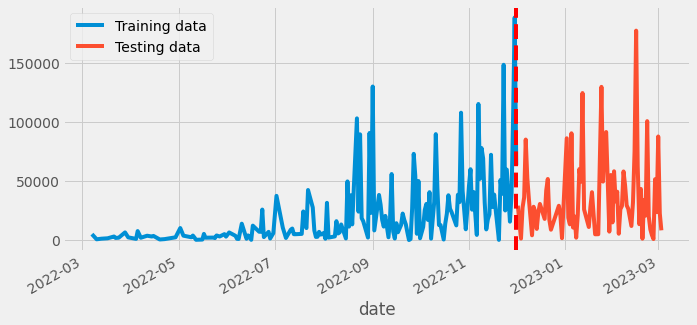

## prophet model

In [284]:
def prophet_model_prediction(train, test, prdiction_variable_column_name):

  '''
  trains prophet model on input 'train' data 
  
  returns:
  --------
  the predicted test data , 
  prediction summary (datetime and predictor),
  and the model in a tuple

  displays:
  ---------
  plots the training, testing, and predicted data



  parameters
  ----------
  train: train dataset index must be timeseries in 'yyyy-mm-dd' format
          and only one attribute to predict (no-multivariable feature)
  test: test dataset index must be timeseries in 'yyyy-mm-dd' format
          and only one attribute to predict (no-multivariable feature)

  prdiction_variable_column_name: the name of the 
                                  column being predicted(string input)

  '''
  ## Model Requirments ##

  # rename columns (prophet requiremnt)
  training_data_prophet = train.reset_index().rename(
      columns = {'date':'ds',
                 prdiction_variable_column_name:'y' }).copy()
  
  test_data_prophet = test.reset_index().rename(
  columns = {'date':'ds',
             prdiction_variable_column_name:'y' }).copy()
  
  # model fit
  model = Prophet()
  model.fit(training_data_prophet)
  
  # model prediction
  prophet_model_prediction = model.predict(test_data_prophet)

  ## Model outputs ##

  # create a summary df and rename the results
  prediction_summry =  prophet_model_prediction[['ds','yhat']]
  prediction_summry = prophet_model_prediction.rename(
      columns= {'ds': 'date', 'yhat': prdiction_variable_column_name})
  
  print('\n==============\nMODEL FIT\n==============')

  fig , ax = plt.subplots(figsize= (10,5))
  train.plot(ax = ax, label = 'Training set', color = 'black' )
  test.plot(ax=ax, label = 'testing set' , color = 'red')
  model.plot(prophet_model_prediction, ax = ax)
  ax.legend(['Training set', 'Testing set', 'predictions'])
  plt.show()

  #model.plot_components(prophet_model_prediction)
  #plt.show

  
  print('\n==============\nMODEL FIT AGG by MONTH\n==============')
  
  df2= pd.concat([train,test])
  df2['date_'] = df2.index
  
  df2 = df2.merge(prediction_summry,
                  how= 'left',left_on = 'date',
                  right_on='date' )
  df2 = df2.set_index(['date'])

  df2 = df2[['date_','quote_x', 'quote_y']]

  df2['month'] = df2.index.month
  df2['year']= df2.index.year

  df2 = df2.rename(columns = {'date_':'date', 'yhat': 'predicted_quote'})
  df2= df2[['date','month', 'year', 'quote_x', 'quote_y']]
  df2.groupby(['year', 'month']).sum().plot()
  plt.xticks(rotation = 40)
  plt.show()
  
  month_summary = df2

  print('\n==============\nERROR METRICS\n==============')

  y_true = test[prdiction_variable_column_name]
  y_pred = prediction_summry[prdiction_variable_column_name]

  print('mean square error:', np.sqrt(mean_squared_error(y_true,y_pred)))
  print('mean absolute error:', mean_absolute_error(y_true,y_pred) )
  print('mean_absolute_percentage_error:',
  mean_absolute_percentage_error(y_true, y_pred), '%')

  return prophet_model_prediction, prediction_summry,month_summary , model

In [ ]:
# train (9 month) and test data (3 month)
train , test = timeSeries_split(df_sum,'2022-12-01')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/nhqvvzi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/7_g56w38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75776', 'data', 'file=/tmp/tmp3w709d2s/nhqvvzi6.json', 'init=/tmp/tmp3w709d2s/7_g56w38.json', 'output', 'file=/tmp/tmp3w709d2s/prophet_modeluw6ec856/prophet_model-20230308192126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MODEL FIT


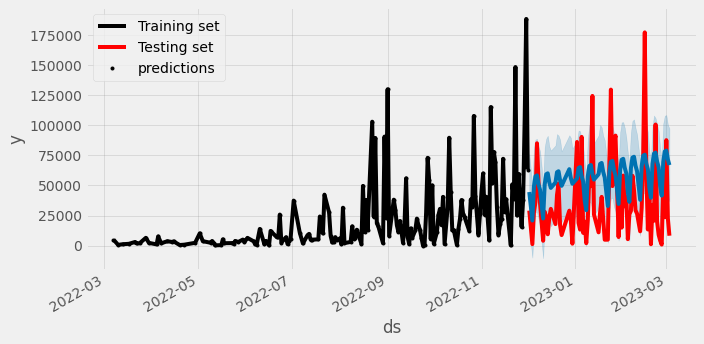


MODEL FIT AGG by MONTH


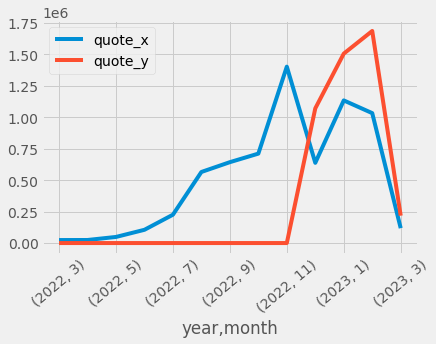


ERROR METRICS
mean square error: 36289.10645130007
mean absolute error: 31773.01296402114
mean_absolute_percentage_error: 361.19262464571074 %


In [285]:
prediction, pred_summary, \
month_summary , model = prophet_model_prediction(train,test, 'quote')

##Count

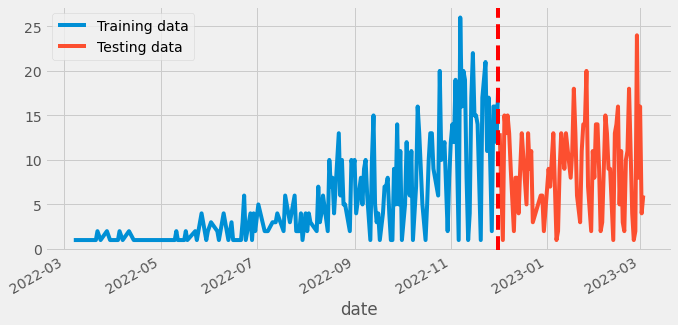

In [278]:
df_count= df.groupby('date').count()
train_count, test_count = timeSeries_split(df_count,'2022-12-01')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/2cy7l5b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/d0u2599b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76133', 'data', 'file=/tmp/tmp3w709d2s/2cy7l5b_.json', 'init=/tmp/tmp3w709d2s/d0u2599b.json', 'output', 'file=/tmp/tmp3w709d2s/prophet_model9mnzd99u/prophet_model-20230308192348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MODEL FIT


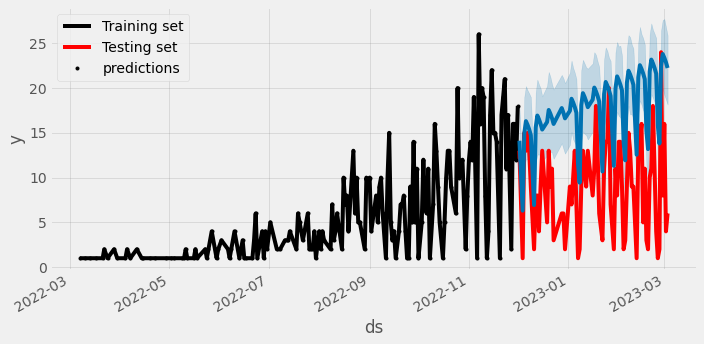


MODEL FIT AGG by MONTH


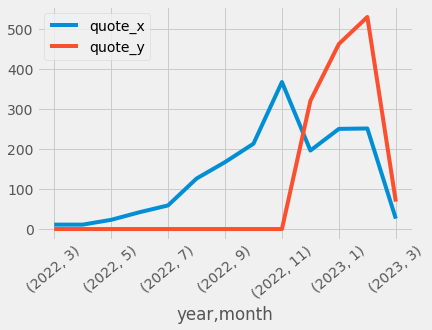


ERROR METRICS
mean square error: 9.715826130358323
mean absolute error: 8.814153105240544
mean_absolute_percentage_error: 204.61911819152925 %


In [286]:
prediction_count, pred_summary_count, month_summary_count,model_count = \
 prophet_model_prediction(train_count,test_count, 'quote')

##Mean

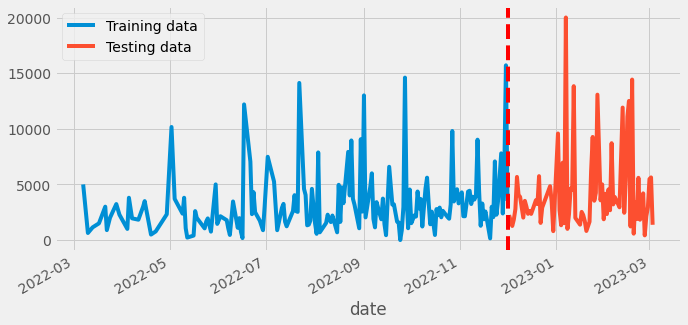

In [280]:
df_mean = df.groupby('date').mean()
train_mean , test_mean = timeSeries_split(df_mean,'2022-12-01')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/2irkizpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w709d2s/xja58zyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85788', 'data', 'file=/tmp/tmp3w709d2s/2irkizpk.json', 'init=/tmp/tmp3w709d2s/xja58zyu.json', 'output', 'file=/tmp/tmp3w709d2s/prophet_model8_yw2gi5/prophet_model-20230308192858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MODEL FIT


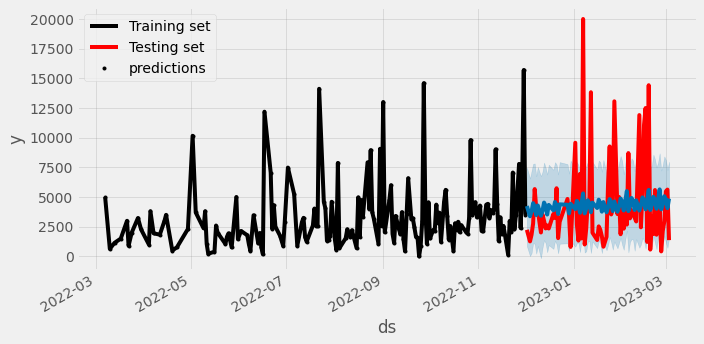


MODEL FIT AGG by MONTH


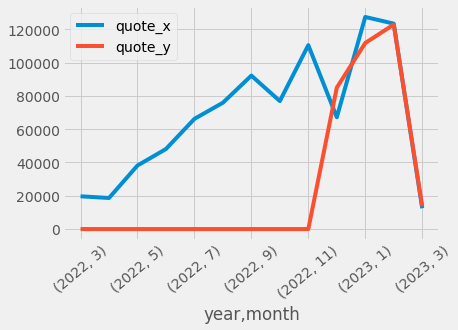


ERROR METRICS
mean square error: 3578.305250742158
mean absolute error: 2525.44476155306
mean_absolute_percentage_error: 98.88350344316258 %


In [291]:
prediction_mean, pred_summary_mean,month_summary_mean,model_mean = \
 prophet_model_prediction(train_mean , test_mean, 'quote')

TypeError: ignored

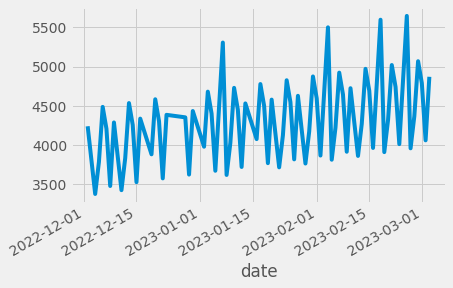

In [290]:
pd.merge(month_summary_count month_summary_mean